In [208]:
import warnings
warnings.filterwarnings("ignore")
import time,math
import numpy as np
from constants import cameraMat
from cv2 import circle,triangulatePoints,cvtColor,line,COLOR_GRAY2RGB,computeCorrespondEpilines,putText,FONT_HERSHEY_SIMPLEX,imwrite,Rodrigues
from myLib import isCollinear,isEqual,swapElements,getSignal,getOrder,reshapeCoord,findNearestC,myProjectionPoints,orderCenterCoord
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
import os
from myLib import estimateFundMatrix_8norm,decomposeEssentialMat
import cv2
from itertools import permutations,combinations


#### Calibration

In [209]:
#dfCSV = np.genfromtxt('dataset_2.6m/working3/cam_all.csv', delimiter=',')
dfCSV = np.genfromtxt('G:/Meu Drive/UFCG/Mestrado/MoCap/CSV datasets/20Jun/camCalib.csv', delimiter=',')
verbose = False
nCameras = 4
recTime = 90
step = 0.01

In [210]:
counter,i,lastTime = np.zeros(nCameras,dtype=np.int32),0,np.zeros(nCameras,dtype=np.int32)
missed,invalid,swap = np.zeros(nCameras,dtype=np.int32),np.zeros(nCameras,dtype=np.int32),np.zeros(nCameras,dtype=np.int32)
lastImgNumber = np.zeros(nCameras,dtype=np.int32)
certainty,intervals,timeIntervals = np.zeros(nCameras,dtype=np.bool8),[],[]
dfOrig,tol = [],0.25
for k in range(nCameras):
    dfOrig.append([])
    intervals.append([])
    timeIntervals.append([])

while i!=dfCSV.shape[0]:
    line = dfCSV[i]
    idx = int(line[8])
    # get points
    undCoord,time,imgNumber = line[0:6].reshape(-1,2),line[6],line[7]
    i+=1
    # add proccesing per occlusion here
    # if ts if not read corectly, discard
    if counter[idx]:
        if abs(time-lastTime[idx])>1e9: 
            if verbose: print('time missmatch')
            missed[idx]+=1
            invalid[idx]+=1
            continue
    # check if sequence is valid
    if imgNumber>lastImgNumber[idx]+1: invalid[idx] = imgNumber-lastImgNumber[idx]
    # order markers per proximity and check collinearity
    if isCollinear(*undCoord) and not isEqual(undCoord,5) and not np.any(undCoord<0):     
        if invalid[idx]>=10 or not counter[idx]: 
            if certainty[idx]:
                beg,end = intervals[idx][-1],counter[idx]-1
                timeIntervals[idx].append([dfOrig[idx][beg,6],dfOrig[idx][end,6]])
                if verbose: print('camera #'+str(idx)+' valid from '+str(round(dfOrig[idx][beg,6]/1e6,2))+'s to '+str(round(dfOrig[idx][end][6]/1e6,2))+'s')
            prev,certainty[idx] = [],False
            intervals[idx].append(counter[idx])
        else:
            if not (counter[idx]-1): prev = np.array(dfOrig[idx][0:6]).reshape(-1,2)
            else: prev = np.array(dfOrig[idx][-1,0:6]).reshape(-1,2)
        undCoord, _ = orderCenterCoord(undCoord,prev)
        undCoord = np.array(undCoord)
    else: 
        if verbose: print('not collinear or equal centroids')
        missed[idx]+=1
        invalid[idx]+=1
        continue
    # update loop variables
    lastTime[idx],lastImgNumber[idx],invalid[idx] = time,imgNumber,0
    if not counter[idx]: dfOrig[idx] = np.hstack((undCoord.reshape(6),time))
    else: dfOrig[idx] = np.vstack((dfOrig[idx],np.hstack((undCoord.reshape(6),time))))
    counter[idx]+=1
    # check if ABC is in order smaller to largest
    if not certainty[idx]:
        for [A,B,C] in undCoord.reshape([-1, 3, 2]):
            if np.linalg.norm(A-B)/np.linalg.norm(C-B)>(2-tol) and np.linalg.norm(A-B)>20:
                swap[idx] += 1
                if swap[idx]>2:    
                    swap[idx],certainty[idx] = 0,True
                    dfOrig[idx][intervals[idx][-1]:counter[idx],0:2],dfOrig[idx][intervals[idx][-1]:counter[idx],4:6] = np.copy(dfOrig[idx][intervals[idx][-1]:counter[idx],4:6]),np.copy(dfOrig[idx][intervals[idx][-1]:counter[idx],0:2])
            if np.linalg.norm(C-B)/np.linalg.norm(A-B)>(2-tol) and np.linalg.norm(C-B)>20:  certainty[idx] = True

# get last interval
for idx in range(nCameras):
    if not len(dfOrig[idx]): continue
    if certainty[idx]:
        beg,end = intervals[idx][-1],counter[idx]-1
        timeIntervals[idx].append([dfOrig[idx][beg,6],dfOrig[idx][end,6]])    
        if verbose: print('camera #'+str(idx)+' valid from '+str(round(dfOrig[idx][beg,6]/1e6,2))+'s to '+str(round(dfOrig[idx][end,6]/1e6,2))+'s')

for i in range(nCameras): 
    print('  >> camera '+str(i)+': '+str(len(dfOrig[i]))+' captured valid images images, missed '+str(int(missed[i]))+' images')
            
## verbose
#os.system('rm pics/cam1/*')
#os.system('rm pics/cam2/*')
'''for idx in range(2):
    for j in range(0,dfOrig[idx].shape[0]):
        pts,name,img,k = dfOrig[idx][j,0:6].reshape(-1,2),int(dfOrig[idx][j,6]),np.ones((540,960,3))*255,0
        for k in range(0,3):
            pt = pts.reshape(-1,2)[k]
            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))
            circle(img,center,10,(255,0,0),5,shift=4)
            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) 
        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)'''


  >> camera 0: 1517 captured valid images images, missed 460 images
  >> camera 1: 1734 captured valid images images, missed 566 images
  >> camera 2: 1568 captured valid images images, missed 480 images
  >> camera 3: 1331 captured valid images images, missed 467 images


"for idx in range(2):\n    for j in range(0,dfOrig[idx].shape[0]):\n        pts,name,img,k = dfOrig[idx][j,0:6].reshape(-1,2),int(dfOrig[idx][j,6]),np.ones((540,960,3))*255,0\n        for k in range(0,3):\n            pt = pts.reshape(-1,2)[k]\n            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))\n            circle(img,center,10,(255,0,0),5,shift=4)\n            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) \n        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)"

In [211]:
from cv2 import line
def drawlines(img1,img2,lines,pts1,pts2):
    r,c = img1.shape
    img1 = cvtColor(img1.astype('float32'),COLOR_GRAY2RGB)
    img2 = cvtColor(img2.astype('float32'),COLOR_GRAY2RGB)
    listColors = [(0,0,255),(0,255,0),(255,0,0)]
    i = 0
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = listColors[i]
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = line(img1, (x0,y0), (x1,y1), color,1)
        img1 = circle(img1,tuple(pt1),5,color,-1)
        img2 = circle(img2,tuple(pt2),5,color,-1)
        i+=1
    return img1,img2


In [212]:
def reproject(points3d,cameraParams):
    """Convert 3-D points to 2-D by projecting onto images."""
    camCoef,rod,t,R  = cameraParams[:,0:4],cameraParams[:,4:7].reshape(-1,3,1),cameraParams[:,7:10].reshape(-1,3,1),[]
    for r in rod: R.append(Rodrigues(r)[0])
    R = np.array(R).reshape(-1,3,3)
    nPts = camCoef.shape[0]
    K = np.transpose(np.array([[camCoef[:,0],np.zeros(nPts),camCoef[:,2]],
                  [np.zeros(nPts),camCoef[:,1],camCoef[:,3]], 
                  [np.zeros(nPts),np.zeros(nPts),np.ones(nPts)]]),(2,0,1))            
    P = np.matmul(K,np.dstack((R, t)))
    newPts3D = np.transpose(np.hstack((points3d,np.ones((points3d.shape[0],1)))).reshape(-1,1,4),(0,2,1))
    newPts = np.matmul(P,newPts3D)
    pts2D = newPts[:,0:2,:]/newPts[:,2,:].reshape(-1,1,newPts.shape[-1])
    return np.transpose(pts2D,(0,2,1)).reshape(-1,2)

def reprojectionError(params,nCameras,points_2d,cameraIdx,pointIdx):
    """Compute residuals. """
    cameraParams = params[:nCameras*10].reshape(-1, 10)
    points_3d = params[nCameras*10:].reshape(-1, 3)
    points_proj = reproject(points_3d[pointIdx.astype(int)], cameraParams[cameraIdx.astype(int)])
    return (points_proj - points_2d).ravel()

def reprojectionError_norm(params,nCameras,points_2d,cameraIdx,pointIdx):
    cameraParams = params[:nCameras*10].reshape(-1, 10)
    points_3d = params[nCameras*10:].reshape(-1, 3)
    points_proj = reproject(points_3d[pointIdx.astype(int)], cameraParams[cameraIdx.astype(int)])
    error = np.sum(np.sum(np.linalg.norm(points_proj - points_2d,axis=1).reshape(-1,3),axis=1))
    return np.asscalar(error)

from scipy.sparse import lil_matrix
from scipy.optimize import least_squares

def bundle_adjustment_sparsity(nCameras,nPts,camIdx,pointIdx):
    m = camIdx.size*2
    n = nCameras*10+nPts*3
    A = lil_matrix((m, n), dtype=int)
    i = np.arange(camIdx.size)
    for s in range(4,10):
        A[2*i[int(camIdx.size/2):],10+s] = 1
        A[2*i[int(camIdx.size/2):]+1,10+s] = 1
    for s in range(3):
        A[2*i,nCameras*10+pointIdx*3+s] = 1
        A[2*i+1,nCameras*10+pointIdx*3+s] = 1
    return A
     

In [213]:
'''def reproject(points3d,cameraParams,camMatrix):
    """Convert 3-D points to 2-D by projecting onto images."""
    K,rod,t,R  = camMatrix.reshape(-1,3,3),cameraParams[:,0:3].reshape(-1,3,1),cameraParams[:,3:6].reshape(-1,3,1),[]
    for r in rod: R.append(Rodrigues(r)[0])
    R = np.array(R).reshape(-1,3,3)
    P = np.matmul(K,np.dstack((R, t)))
    newPts3D = np.transpose(np.hstack((points3d,np.ones((points3d.shape[0],1)))).reshape(-1,1,4),(0,2,1))
    newPts = np.matmul(P,newPts3D)
    pts2D = newPts[:,0:2,:]/newPts[:,2,:].reshape(-1,1,newPts.shape[-1])
    return np.transpose(pts2D,(0,2,1)).reshape(-1,2)

def reprojectionError(params,nCameras,points_2d,cameraIdx,pointIdx,camMatrix):
    """Compute residuals. """
    cameraParams = params[:nCameras*6].reshape(-1, 6)
    points_3d = params[nCameras*6:].reshape(-1, 3)
    points_proj = reproject(points_3d[pointIdx.astype(int)], cameraParams[cameraIdx.astype(int)],np.array(camMatrix)[cameraIdx.astype(int)])
    error = np.sum(np.sum(np.linalg.norm(points_proj - points_2d,axis=1).reshape(-1,3),axis=1))
    return np.asscalar(error)

def bundle_adjustment_sparsity(nCameras,nPts,camIdx,pointIdx):
    m = 1
    n = nCameras*6+nPts*3
    A = lil_matrix((m, n), dtype=int)
    for s in range(n):
        A[0,s] = 1
    return A'''

'def reproject(points3d,cameraParams,camMatrix):\n    """Convert 3-D points to 2-D by projecting onto images."""\n    K,rod,t,R  = camMatrix.reshape(-1,3,3),cameraParams[:,0:3].reshape(-1,3,1),cameraParams[:,3:6].reshape(-1,3,1),[]\n    for r in rod: R.append(Rodrigues(r)[0])\n    R = np.array(R).reshape(-1,3,3)\n    P = np.matmul(K,np.dstack((R, t)))\n    newPts3D = np.transpose(np.hstack((points3d,np.ones((points3d.shape[0],1)))).reshape(-1,1,4),(0,2,1))\n    newPts = np.matmul(P,newPts3D)\n    pts2D = newPts[:,0:2,:]/newPts[:,2,:].reshape(-1,1,newPts.shape[-1])\n    return np.transpose(pts2D,(0,2,1)).reshape(-1,2)\n\ndef reprojectionError(params,nCameras,points_2d,cameraIdx,pointIdx,camMatrix):\n    """Compute residuals. """\n    cameraParams = params[:nCameras*6].reshape(-1, 6)\n    points_3d = params[nCameras*6:].reshape(-1, 3)\n    points_proj = reproject(points_3d[pointIdx.astype(int)], cameraParams[cameraIdx.astype(int)],np.array(camMatrix)[cameraIdx.astype(int)])\n    error = 

interpolated 1591 images between cams 0 and 1
[INFO] Computing fundamental and essential matrix between cameras 0-1
	Scale between real world and triang. point cloud is:  402.53
	L_AC >> mean = 15.6212cm, std. dev = 0.4006cm, rms = 0.4082cm
	L_AB >> mean = 5.6313cm, std. dev = 0.1173cm, rms = 0.176cm
	L_BC >> mean = 10.0394cm, std. dev = 0.3195cm, rms = 0.3576cm
	Images distant more than 1% from the real value = 746/1591
[INFO] Refining fundamental matrix estimation
	Scale between real world and triang. point cloud is:  392.25
	L_AC >> mean = 15.6346cm, std. dev = 0.1247cm, rms = 0.1408cm
	L_AB >> mean = 5.6004cm, std. dev = 0.0702cm, rms = 0.1225cm
	L_BC >> mean = 10.0652cm, std. dev = 0.1218cm, rms = 0.1816cm


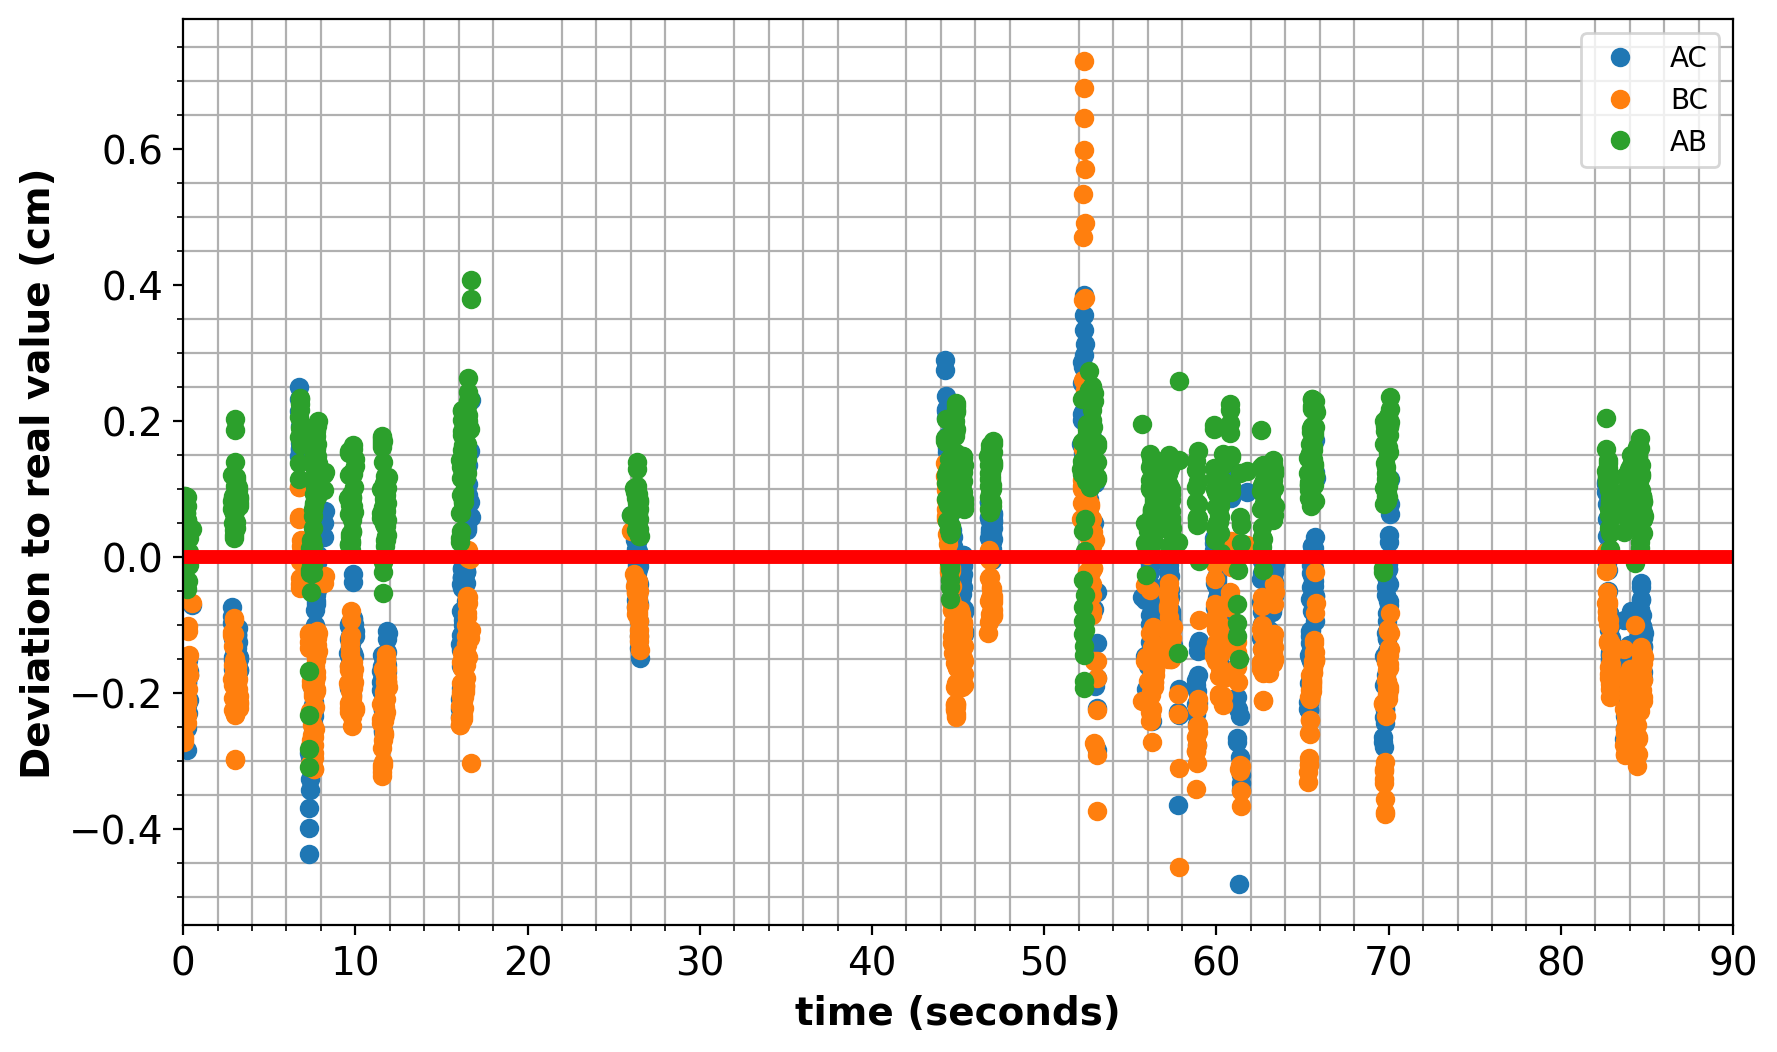

[INFO] Mean reprojection error (in px): 1.672675775984572
[INFO] Max dev. (in cm): 0.729481443330533
--
interpolated 510 images between cams 0 and 2
[INFO] Computing fundamental and essential matrix between cameras 0-2
	Scale between real world and triang. point cloud is:  596.64
	L_AC >> mean = 15.6349cm, std. dev = 0.3126cm, rms = 0.3194cm
	L_AB >> mean = 5.6213cm, std. dev = 0.135cm, rms = 0.1815cm
	L_BC >> mean = 10.0428cm, std. dev = 0.2596cm, rms = 0.3035cm
	Images distant more than 1% from the real value = 271/510
[INFO] Refining fundamental matrix estimation
	Scale between real world and triang. point cloud is:  594.26
	L_AC >> mean = 15.6259cm, std. dev = 0.0806cm, rms = 0.1095cm
	L_AB >> mean = 5.6254cm, std. dev = 0.0789cm, rms = 0.1481cm
	L_BC >> mean = 10.0271cm, std. dev = 0.0915cm, rms = 0.1956cm


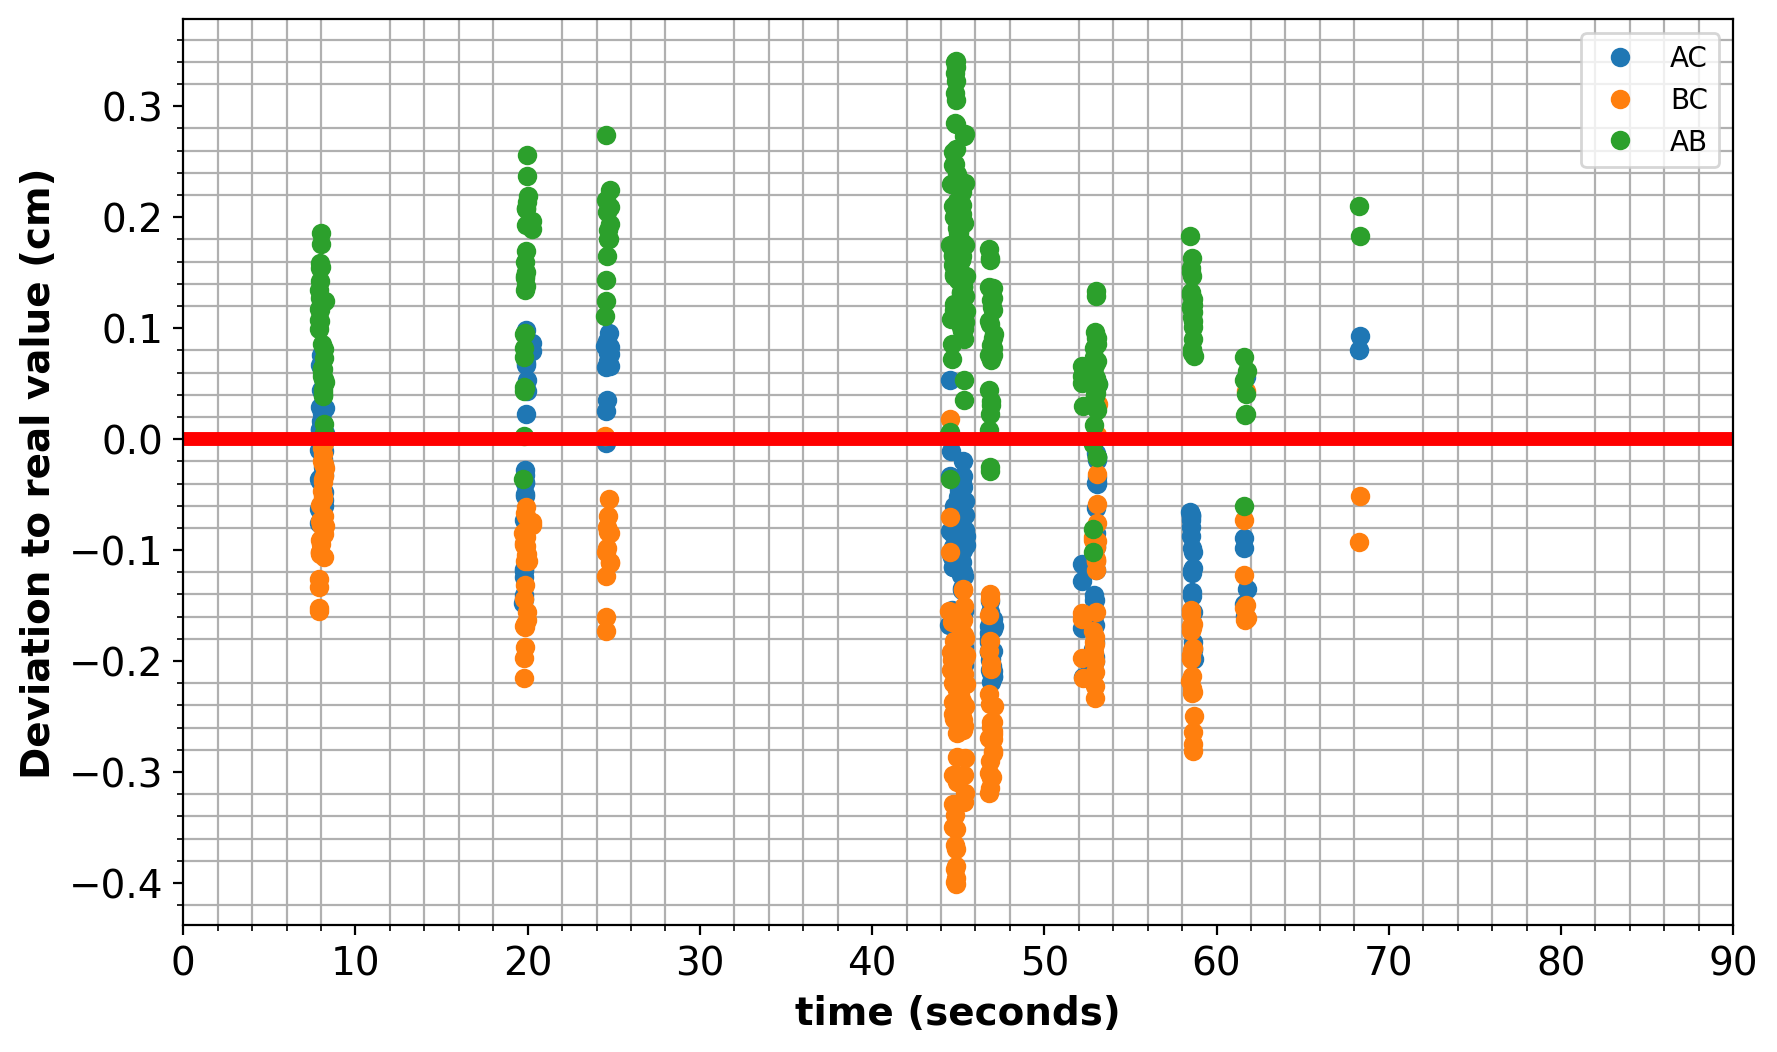

[INFO] Mean reprojection error (in px): 0.6735614808845279
[INFO] Max dev. (in cm): 0.34116944667236293
--
interpolated 1211 images between cams 0 and 3
[INFO] Computing fundamental and essential matrix between cameras 0-3
	Scale between real world and triang. point cloud is:  435.74
	L_AC >> mean = 15.5282cm, std. dev = 0.6621cm, rms = 0.684cm
	L_AB >> mean = 5.7921cm, std. dev = 1.2326cm, rms = 1.2667cm
	L_BC >> mean = 10.0822cm, std. dev = 0.6096cm, rms = 0.6209cm
	Images distant more than 1% from the real value = 1008/1211
[INFO] Refining fundamental matrix estimation
	Scale between real world and triang. point cloud is:  440.45
	L_AC >> mean = 15.6163cm, std. dev = 0.0845cm, rms = 0.1189cm
	L_AB >> mean = 5.6162cm, std. dev = 0.6297cm, rms = 0.6403cm
	L_BC >> mean = 10.1108cm, std. dev = 0.2544cm, rms = 0.2696cm


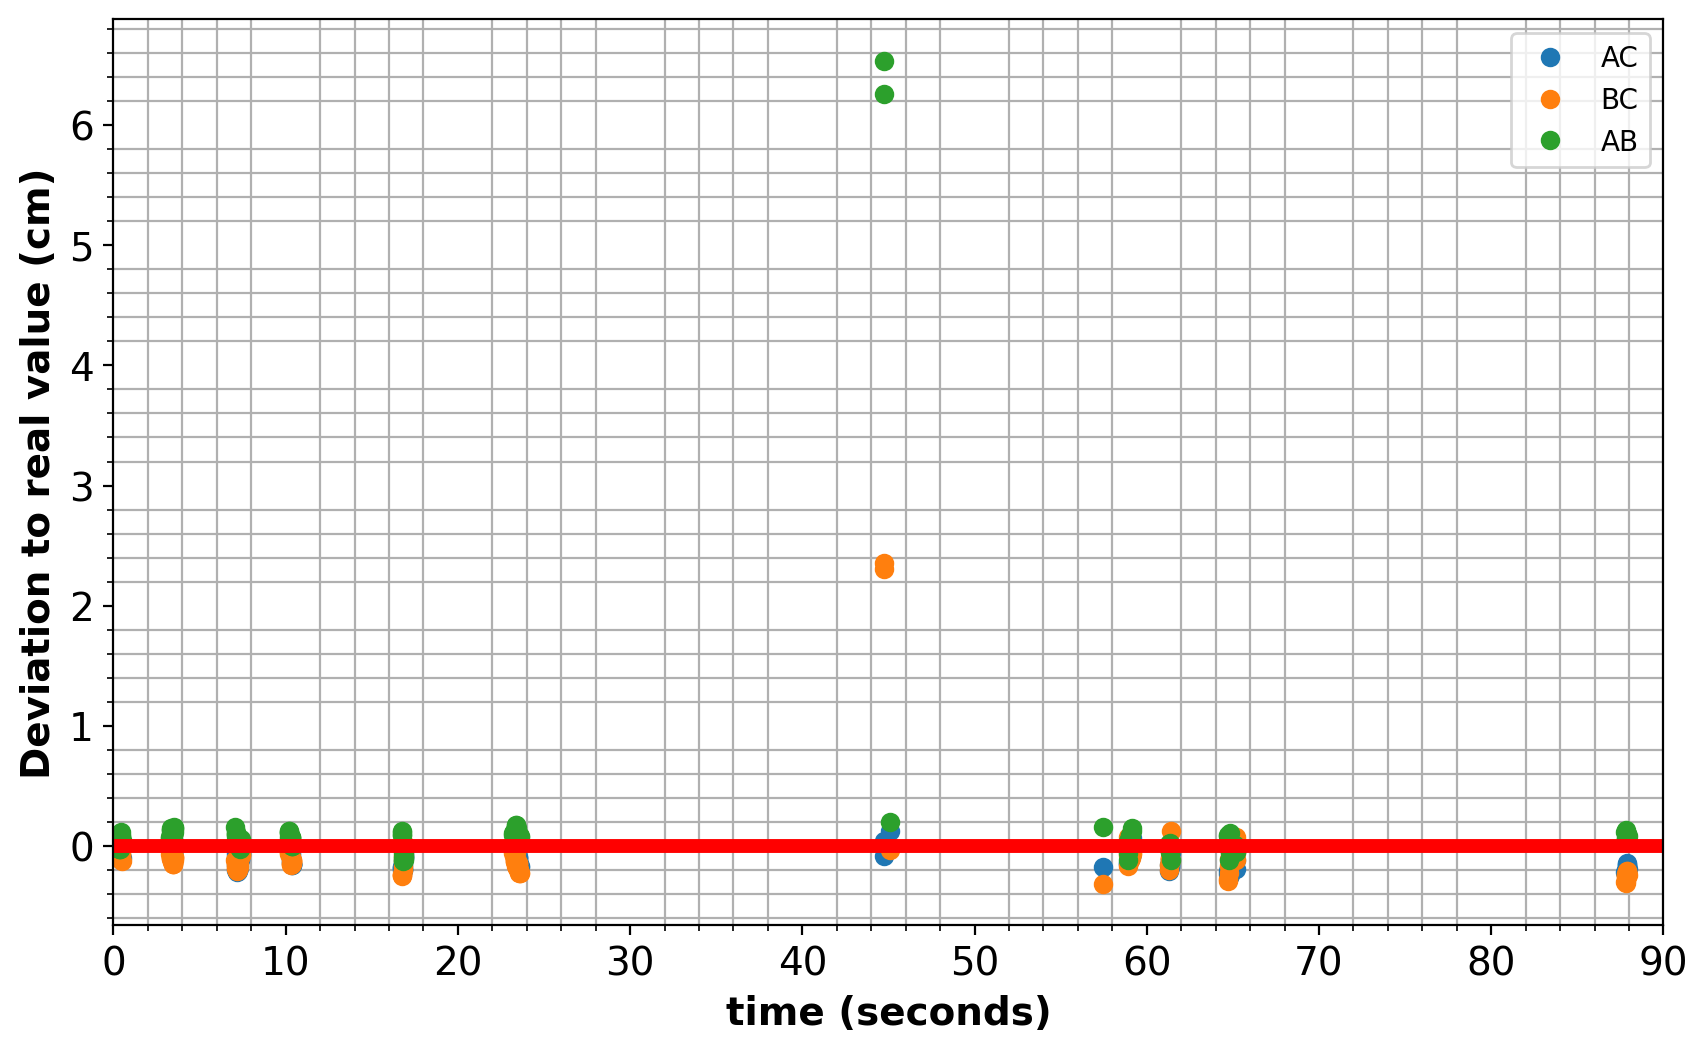

[INFO] Mean reprojection error (in px): 5.469244899725766
[INFO] Max dev. (in cm): 6.536257547460815
--
interpolated 1313 images between cams 1 and 2
[INFO] Computing fundamental and essential matrix between cameras 1-2
	Scale between real world and triang. point cloud is:  461.27
	L_AC >> mean = 15.6571cm, std. dev = 0.9395cm, rms = 0.9405cm
	L_AB >> mean = 5.7032cm, std. dev = 0.1355cm, rms = 0.2442cm
	L_BC >> mean = 10.0187cm, std. dev = 0.8372cm, rms = 0.8566cm
	Images distant more than 1% from the real value = 1077/1313
[INFO] Refining fundamental matrix estimation
	Scale between real world and triang. point cloud is:  457.76
	L_AC >> mean = 15.647cm, std. dev = 0.0895cm, rms = 0.104cm
	L_AB >> mean = 5.5751cm, std. dev = 0.1302cm, rms = 0.1504cm
	L_BC >> mean = 10.1057cm, std. dev = 0.1349cm, rms = 0.1646cm


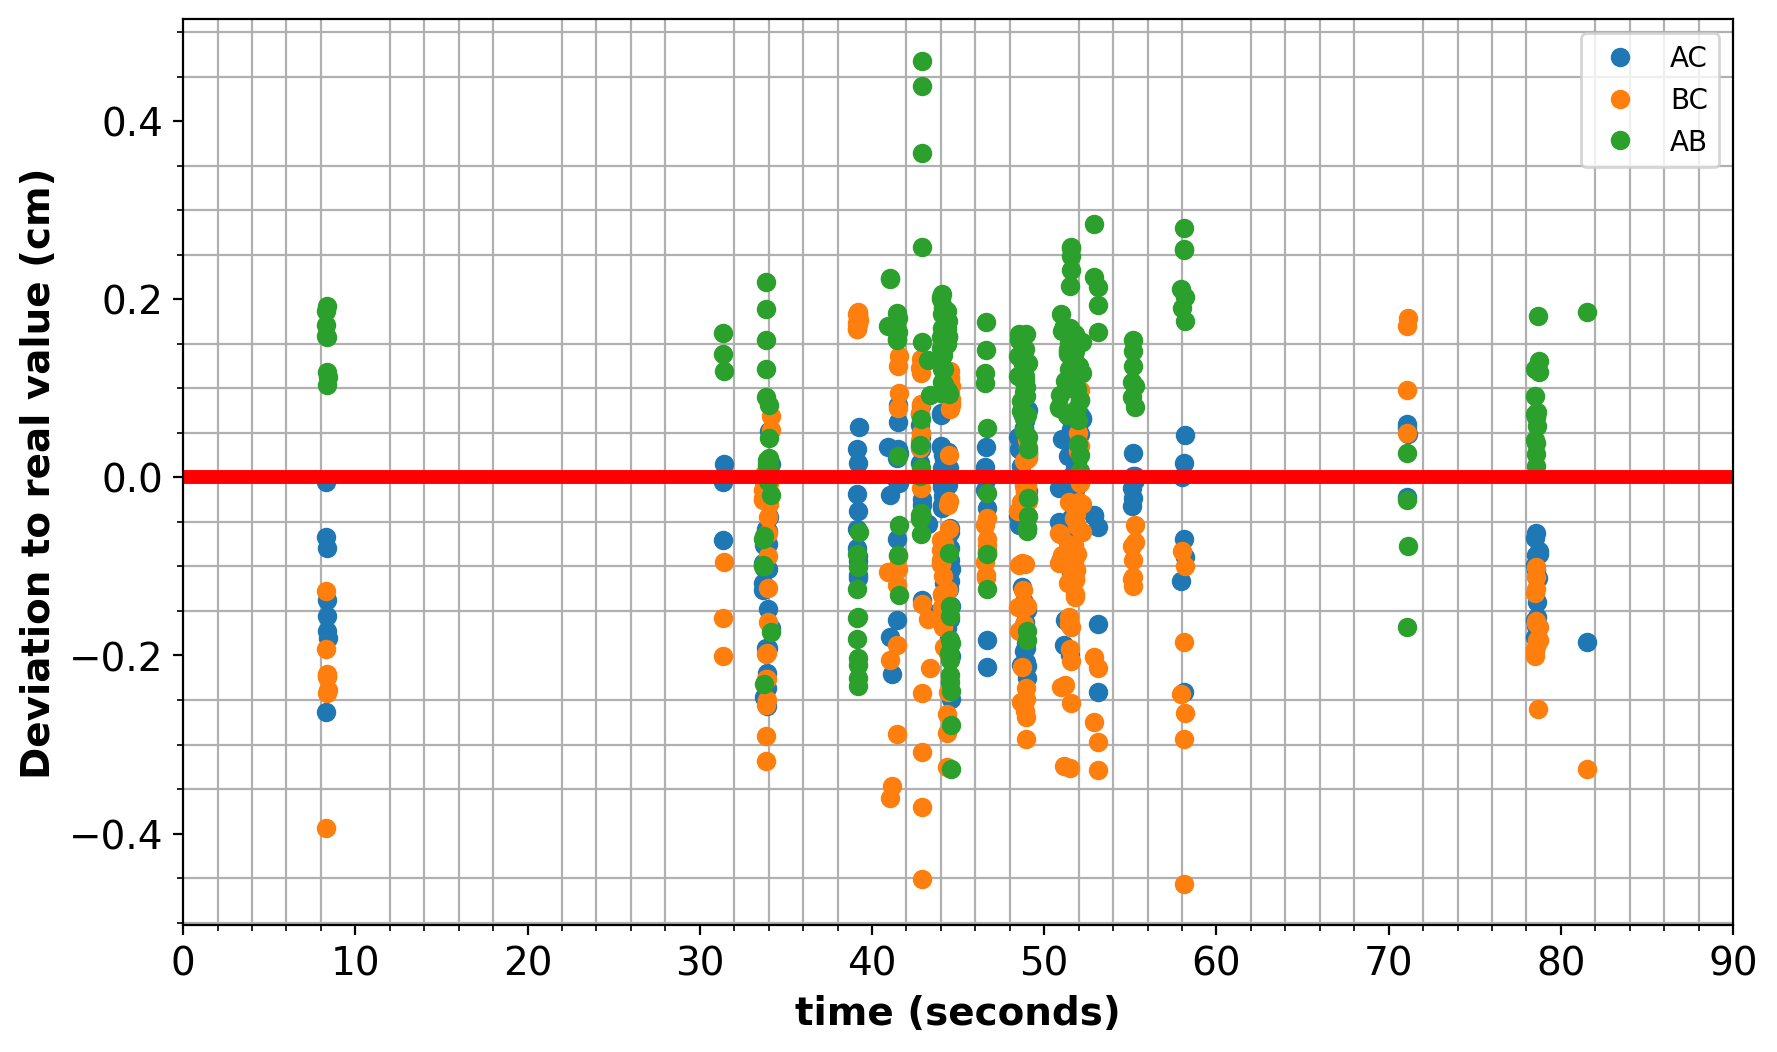

[INFO] Mean reprojection error (in px): 1.2966268449082663
[INFO] Max dev. (in cm): 0.46793843953923275
--
interpolated 1251 images between cams 1 and 3
[INFO] Computing fundamental and essential matrix between cameras 1-3
	Scale between real world and triang. point cloud is:  577.5
	L_AC >> mean = 16.2163cm, std. dev = 4.046cm, rms = 4.0788cm
	L_AB >> mean = 5.9742cm, std. dev = 1.5619cm, rms = 1.6323cm
	L_BC >> mean = 10.5193cm, std. dev = 2.6267cm, rms = 2.646cm
	Images distant more than 1% from the real value = 1137/1251
[INFO] Refining fundamental matrix estimation
	Scale between real world and triang. point cloud is:  586.81
	L_AC >> mean = 15.6629cm, std. dev = 0.9689cm, rms = 0.9696cm
	L_AB >> mean = 5.6766cm, std. dev = 0.5021cm, rms = 0.5323cm
	L_BC >> mean = 10.0555cm, std. dev = 0.7001cm, rms = 0.7149cm


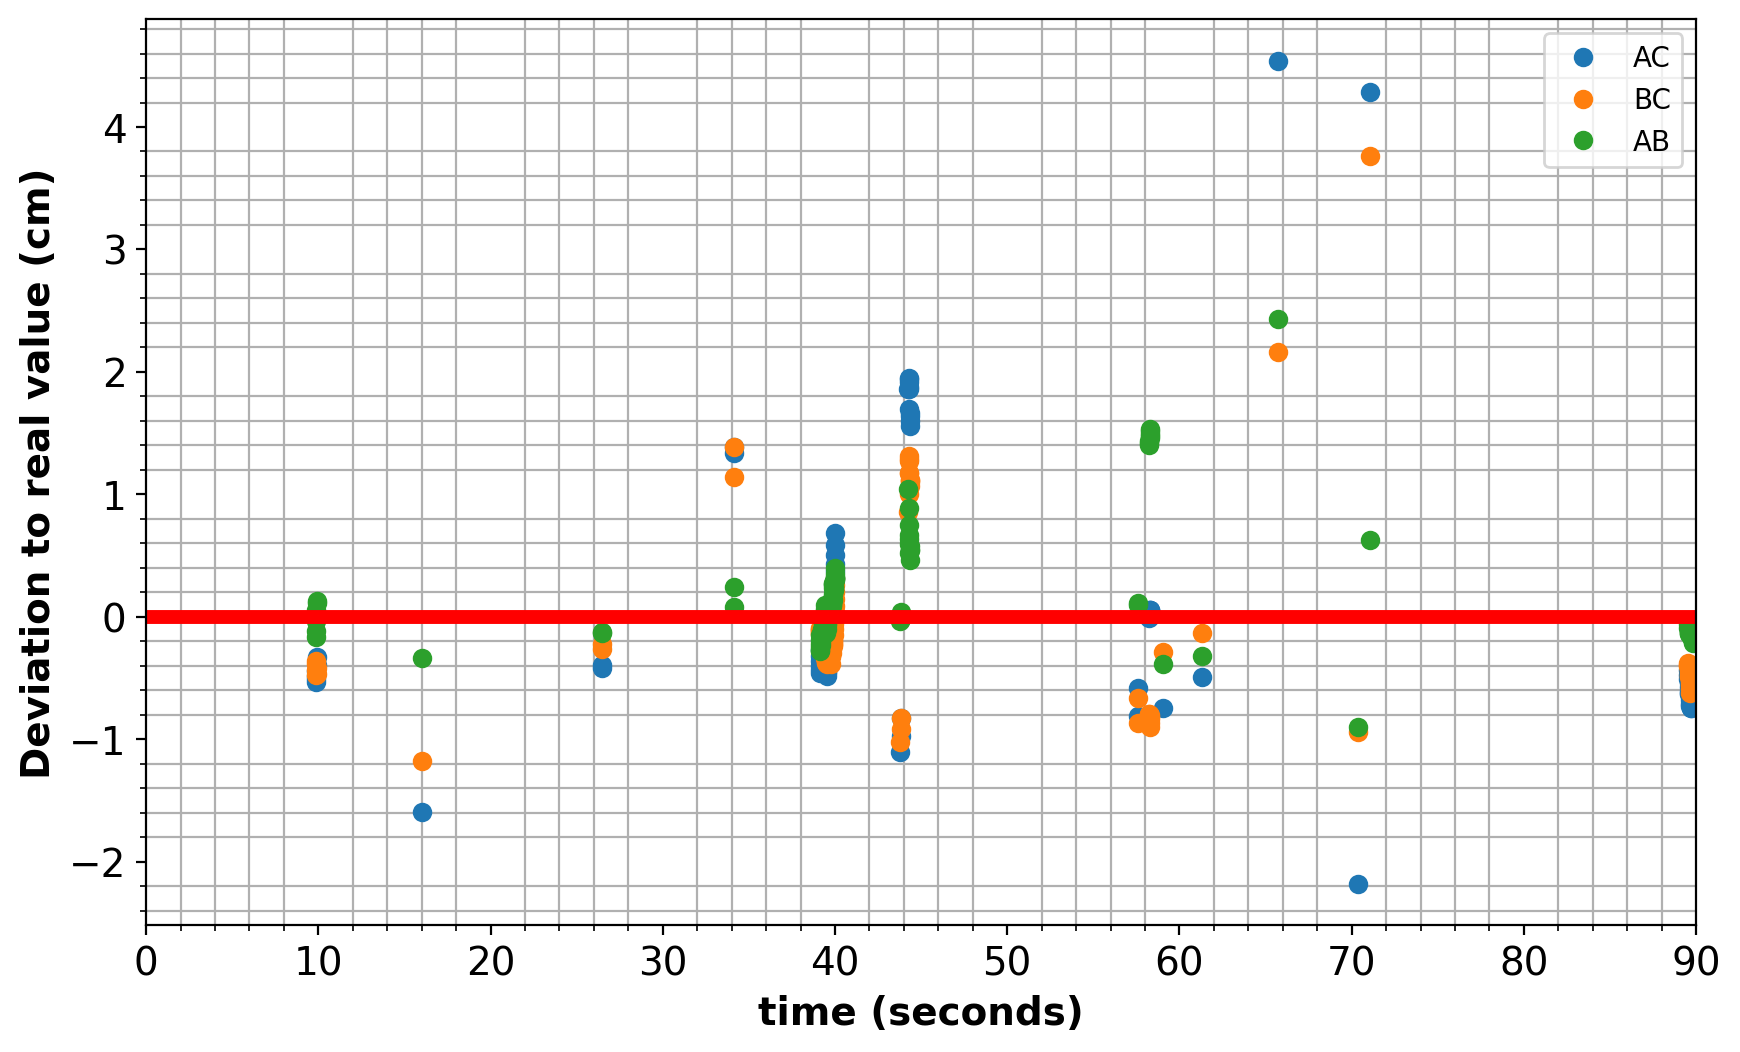

[INFO] Mean reprojection error (in px): 4.62573841807218
[INFO] Max dev. (in cm): 4.542088452960172
--
interpolated 1085 images between cams 2 and 3
[INFO] Computing fundamental and essential matrix between cameras 2-3
	Scale between real world and triang. point cloud is:  395.65
	L_AC >> mean = 15.473cm, std. dev = 0.9263cm, rms = 0.9537cm
	L_AB >> mean = 5.7515cm, std. dev = 1.1013cm, rms = 1.1297cm
	L_BC >> mean = 10.3072cm, std. dev = 1.2289cm, rms = 1.2335cm
	Images distant more than 1% from the real value = 810/1085
[INFO] Refining fundamental matrix estimation
	Scale between real world and triang. point cloud is:  407.19
	L_AC >> mean = 15.6333cm, std. dev = 0.2133cm, rms = 0.2235cm
	L_AB >> mean = 5.587cm, std. dev = 0.1764cm, rms = 0.1967cm
	L_BC >> mean = 10.1079cm, std. dev = 0.3142cm, rms = 0.3274cm


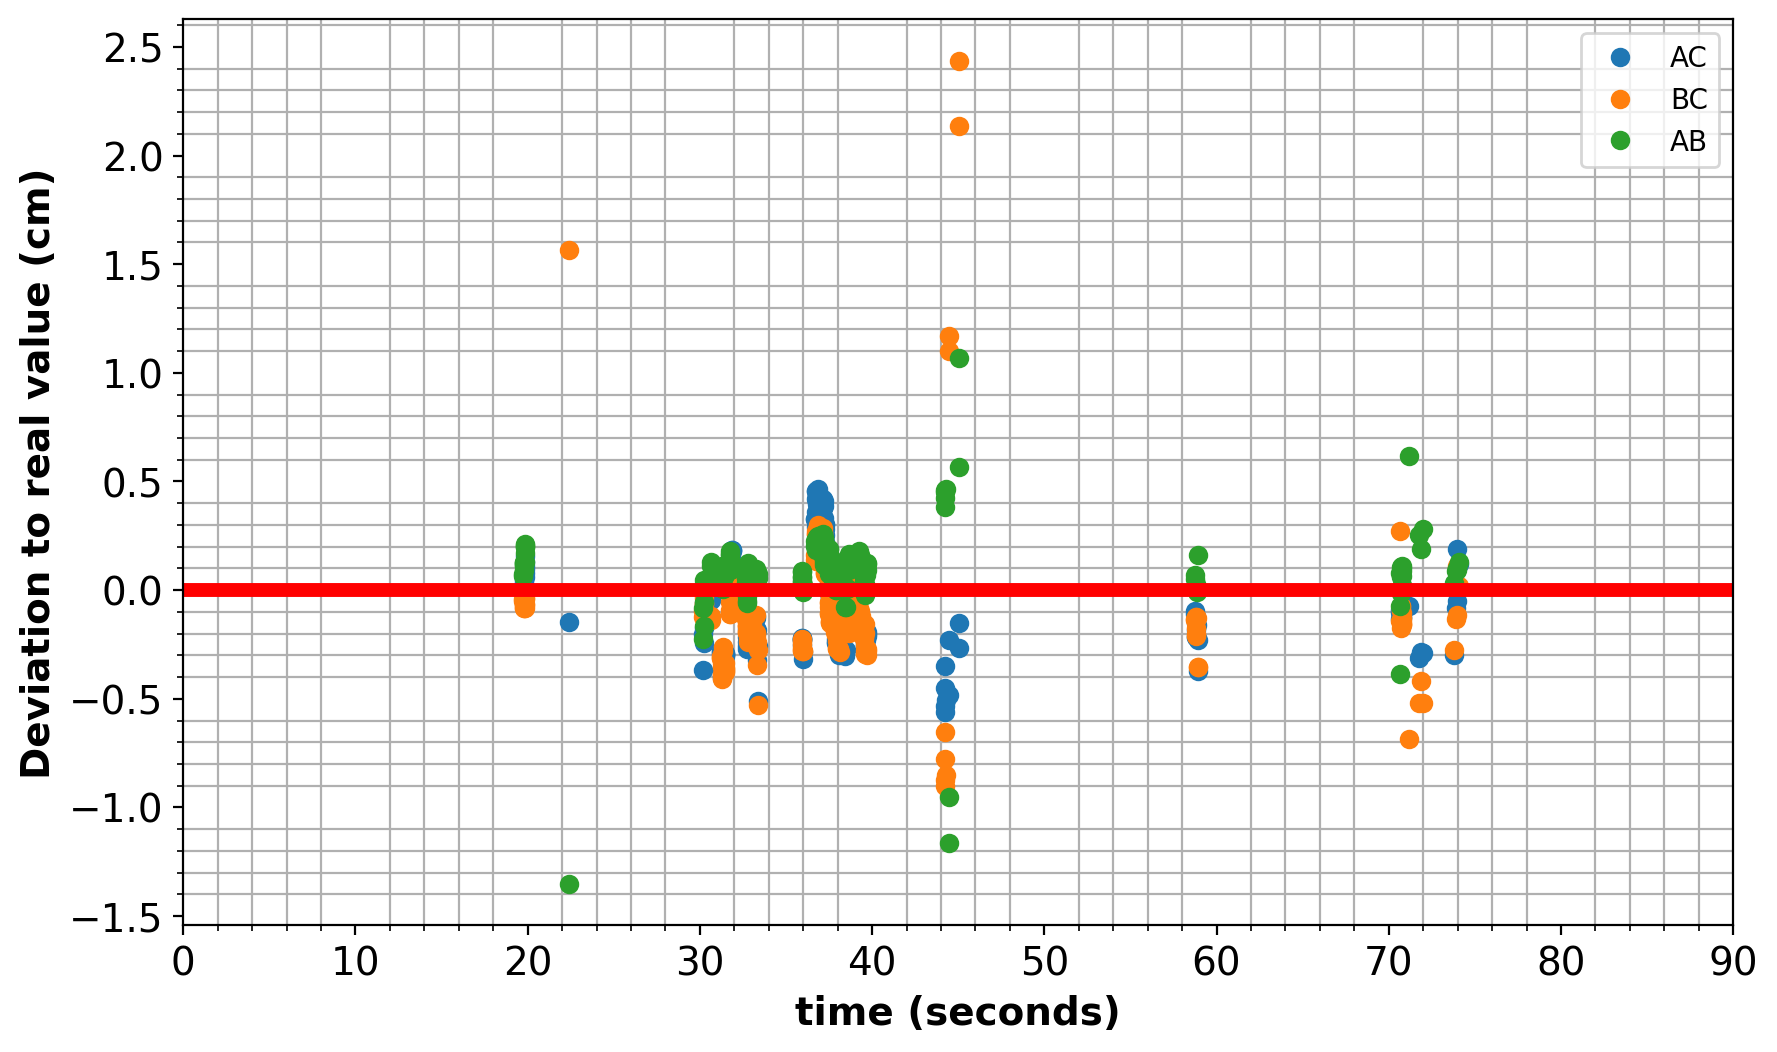

[INFO] Mean reprojection error (in px): 0.8265123948376274
[INFO] Max dev. (in cm): 2.4369905205229028
--


In [214]:
rotation,translation,scale,FMatrix,points3D_perPair,repError = [],[],[],[],[],[]
allIdx = list(combinations(list(range(nCameras)),2))
verbose = False
for [m,n] in allIdx:
    # compute valid time intersection for interpolation
    intersections = [[max(first[0], second[0]), min(first[1], second[1])]  
                        for first in timeIntervals[m] for second in timeIntervals[n]  
                        if max(first[0], second[0]) <= min(first[1], second[1])]
    dfInterp = np.zeros((int(recTime/step),2*6+1))
    dfInterp[:,-1] = np.linspace(0,recTime,int(recTime/step))
    for [beg,end] in intersections:
        for idx in [m,n]:
            validIdx = [i for i in range(0,dfOrig[idx].shape[0]) if beg<=dfOrig[idx][i,-1]<=end]
            coord,time = dfOrig[idx][validIdx,0:6],dfOrig[idx][validIdx,6]/1e6
            if time.shape[0]<=2: continue
            lowBound,highBound = math.ceil(time[0]/step),math.floor(time[-1]/step)
            if verbose: print('interpolated #'+str(idx+1)+' from '+str(round(lowBound*step,2))+'s to '+str(round(highBound*step,2))+'s')
            tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
            if time.shape[0]<=2: continue
            ff = CubicSpline(time,coord,axis=0)
            if idx == m: dfInterp[tNew,0:6] = ff(tNew*step)
            else: dfInterp[tNew,6:12] = ff(tNew*step)
    # get data
    dfInterp = np.delete(dfInterp,np.unique([i for i in range(0,dfInterp.shape[0]) for idx in range(2) if not np.any(dfInterp[i][idx*6:idx*6+6])]),axis=0)
    if dfInterp.shape[0] < 10: 
        print('[ERROR] no valid image intersection for cameras '+str(m)+' and '+str(n))
        break
    centroids1,centroids2 = dfInterp[:,0:6].reshape(-1,2),dfInterp[:,6:12].reshape(-1,2)
    print('interpolated '+str(dfInterp.shape[0])+' images between cams '+str(m)+' and '+str(n))
    # get fundamental and essential matrices 
    print('[INFO] Computing fundamental and essential matrix between cameras '+str(m)+'-'+str(n))
    # get fundamental and essential matrices
    F,_ = estimateFundMatrix_8norm(np.array(centroids1),np.array(centroids2),verbose=verbose)
    E = np.matmul(cameraMat[n].T, np.matmul(F, cameraMat[m]))
    if verbose: print("\nEssenc. Mat.\n", E.round(4))
    # decompose to rotation and translation between cameras
    R, t = decomposeEssentialMat(E, cameraMat[m], cameraMat[n], np.array(centroids1), np.array(centroids2))
    if np.any(np.isnan(R)): print('no valid rotation matrix')
    else:
        if verbose:
            print("\nRot. Mat.\n", R.round(4))
            print("\nTrans. Mat.\n", t.round(4))
    P1,P2 = np.hstack((cameraMat[m], [[0.], [0.], [0.]])),np.matmul(cameraMat[n], np.hstack((R, t.T)))
    projPt1,projPt2 = myProjectionPoints(np.array(centroids1)),myProjectionPoints(np.array(centroids2))
    points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
    points3d = (points4d[:3, :]/points4d[3, :]).T
    if points3d[0, 2] < 0: points3d = -points3d
    tot,L_real_AC,L_real_AB,L_real_BC,L_AC_vec,L_BC_vec,L_AB_vec,k,false_idx,time_idx = 0,15.7,5.5,10.2,[],[],[],0,[],[]
    # compute sdt deviation and plot beautiful stuff
    for [A, B, C] in points3d.reshape([-1, 3, 3]):
        L_rec_AC,L_rec_BC,L_rec_AB = np.linalg.norm(A-C),np.linalg.norm(B-C),np.linalg.norm(A-B)
        tot = tot + L_real_AC/L_rec_AC + L_real_BC/L_rec_BC + L_real_AB/L_rec_AB
        k = k + 3
        L_AC_vec.append(L_rec_AC)
        L_BC_vec.append(L_rec_BC)
        L_AB_vec.append(L_rec_AB)   
    lamb = tot/k
    print('\tScale between real world and triang. point cloud is: ', lamb.round(2))
    print('\tL_AC >> mean = ' + str((np.mean(L_AC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AC_vec)*lamb-L_real_AC)))).round(4)) + "cm")
    print('\tL_AB >> mean = ' + str((np.mean(L_AB_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AB_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AB_vec)*lamb-L_real_AB)))).round(4)) + "cm")
    print('\tL_BC >> mean = ' + str((np.mean(L_BC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_BC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_BC_vec)*lamb-L_real_BC)))).round(4)) + "cm")
    '''fig = plt.figure(figsize=(10, 6), dpi=200)
    L_AC_vec_plot,L_BC_vec_plot,L_AB_vec_plot = np.array(L_AC_vec)*lamb - L_real_AC,np.array(L_BC_vec)*lamb - L_real_BC,np.array(L_AB_vec)*lamb - L_real_AB
    plt.plot(dfInterp[:,-1],L_AC_vec_plot, 'o', label="AC")
    plt.plot(dfInterp[:,-1],L_BC_vec_plot, 'o', label="BC")
    plt.plot(dfInterp[:,-1],L_AB_vec_plot, 'o', label="AB")
    plt.axhline(y=0.0, color='r', linestyle='-',linewidth=5)
    plt.grid()
    plt.xlabel("time (seconds)",fontsize=14, fontweight='bold')
    plt.ylabel("Deviation to real value (cm)",fontsize=14,fontweight='bold')
    plt.legend()
    ax = fig.axes
    ax[0].minorticks_on()
    plt.grid(which='both')
    plt.xlim(0,recTime)
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    plt.draw()
    plt.show()'''
    points3d_new,i,k= points3d*lamb,0,0
    for [A, B, C] in points3d_new.reshape([-1, 3, 3]):
        L_reconst = np.sqrt(np.sum((A-C)**2, axis=0))
        valid = abs(L_real_AC-L_reconst)/L_real_AC < 0.01
        if not valid: 
            i = i + 1
            false_idx.extend((k,k+1,k+2))
            time_idx.append(int(k/3))
        k+=3
    print("\tImages distant more than 1% from the real value = " + str(i)+'/'+str(int(points3d.shape[0]/3)))
    # refining estimation
    print("[INFO] Refining fundamental matrix estimation")
    centroids1,centroids2,dfInterp=np.delete(centroids1,false_idx,axis=0),np.delete(centroids2,false_idx,axis=0),np.delete(dfInterp,time_idx,axis=0)
    if m==1 and n==2:
        np.savetxt('centroid1.csv',centroids1,delimiter=',')
        np.savetxt('centroid2.csv',centroids2,delimiter=',')      
    points3d = np.delete(points3d,false_idx,axis=0)    
    # bundle adjustment
    cameraParams = []
    for i in [m,n]: 
        K = cameraMat[i]
        if not len(cameraParams): cameraParams = np.hstack((np.array([K[0][0],K[1][1],K[0][2],K[1][2]]).reshape(-1,4),Rodrigues(np.identity(3))[0].reshape(-1,3),np.zeros((1,3))))
        else: cameraParams=np.vstack((cameraParams,np.hstack((np.array([K[0][0],K[1][1],K[0][2],K[1][2]]).reshape(-1,4),Rodrigues(R)[0].reshape(-1,3),t.reshape(-1,3)))))
    x = np.hstack((cameraParams.ravel(), points3d.ravel()))
    nCam,points_2d = 2,np.vstack((centroids1,centroids2))
    cameraIdx = np.hstack((np.zeros(centroids1.shape[0]),np.ones(centroids2.shape[0])))
    pointIdx = np.hstack(([i for i in range(centroids1.shape[0])],[i for i in range(centroids2.shape[0])]))
    nPts = points3d.shape[0]
    r = reprojectionError(x,nCam,points_2d,cameraIdx,pointIdx)
    #plt.plot(r)
    A = bundle_adjustment_sparsity(nCam,nPts,cameraIdx,pointIdx)
    res = least_squares(reprojectionError, x, jac_sparsity=A, verbose=0, x_scale='jac', ftol=1e-6, method='trf',
                        args=(nCam,points_2d,cameraIdx,pointIdx))
    #plt.plot(res.fun)
    rot,tra,K = [],[],[]
    for cameraParams in res.x[0:20].reshape(2,10):
        R,t = cameraParams[4:7].reshape(-1,3),cameraParams[7:10].reshape(-1,3)
        camCoef = cameraParams[0:4]
        K.append(np.array([[camCoef[0],0,camCoef[2]],[0,camCoef[1],camCoef[3]],[0,0,1]]))
        rot.append(Rodrigues(R)[0])
        tra.append(t) 
    P1,P2 = np.matmul(K[0], np.hstack((rot[0], tra[0].T))),np.matmul(K[1], np.hstack((rot[1], tra[1].T)))
    # get fundamental and essential matrices
    '''F,_ = estimateFundMatrix_8norm(np.array(centroids1),np.array(centroids2),verbose = 0)
    E = np.matmul(cameraMat[n].T, np.matmul(F, cameraMat[m]))
    if verbose: print("\nEssenc. Mat.\n", E.round(4))
    # decompose to rotation and translation between cameras
    R, t = decomposeEssentialMat(E, cameraMat[m], cameraMat[n], np.array(centroids1), np.array(centroids2))
    if np.any(np.isnan(R)): print('no valid rotation matrix')
    else:
        if verbose:
            print("\nRot. Mat.\n", R.round(4))
            print("\nTrans. Mat.\n", t.round(4))
    P1,P2 = np.hstack((cameraMat[m], [[0.], [0.], [0.]])),np.matmul(cameraMat[n], np.hstack((R, t.T)))'''
    projPt1,projPt2 = myProjectionPoints(np.array(centroids1)),myProjectionPoints(np.array(centroids2))
    points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
    points3d = (points4d[:3, :]/points4d[3, :]).T
    if points3d[0, 2] < 0: points3d = -points3d
    tot,L_real_AC,L_real_AB,L_real_BC,L_AC_vec,L_BC_vec,L_AB_vec,k,false_idx = 0,15.7,5.5,10.2,[],[],[],0,[]
    # compute sdt deviation and plot beautiful stuff
    for [A, B, C] in points3d.reshape([-1, 3, 3]):
        L_rec_AC,L_rec_BC,L_rec_AB = np.linalg.norm(A-C),np.linalg.norm(B-C),np.linalg.norm(A-B)
        tot = tot + L_real_AC/L_rec_AC + L_real_BC/L_rec_BC + L_real_AB/L_rec_AB
        k = k + 3
        L_AC_vec.append(L_rec_AC)
        L_BC_vec.append(L_rec_BC)
        L_AB_vec.append(L_rec_AB)   
    lamb = tot/k
    print('\tScale between real world and triang. point cloud is: ', lamb.round(2))
    print('\tL_AC >> mean = ' + str((np.mean(L_AC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AC_vec)*lamb-L_real_AC)))).round(4)) + "cm")
    print('\tL_AB >> mean = ' + str((np.mean(L_AB_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AB_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AB_vec)*lamb-L_real_AB)))).round(4)) + "cm")
    print('\tL_BC >> mean = ' + str((np.mean(L_BC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_BC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_BC_vec)*lamb-L_real_BC)))).round(4)) + "cm")
    fig = plt.figure(figsize=(10, 6), dpi=200)
    L_AC_vec_plot,L_BC_vec_plot,L_AB_vec_plot = np.array(L_AC_vec)*lamb - L_real_AC,np.array(L_BC_vec)*lamb - L_real_BC,np.array(L_AB_vec)*lamb - L_real_AB
    plt.plot(dfInterp[:,-1],L_AC_vec_plot, 'o', label="AC")
    plt.plot(dfInterp[:,-1],L_BC_vec_plot, 'o', label="BC")
    plt.plot(dfInterp[:,-1],L_AB_vec_plot, 'o', label="AB")
    plt.axhline(y=0.0, color='r', linestyle='-',linewidth=5)
    plt.grid()
    plt.xlabel("time (seconds)",fontsize=14, fontweight='bold')
    plt.ylabel("Deviation to real value (cm)",fontsize=14,fontweight='bold')
    plt.legend()
    ax = fig.axes
    ax[0].minorticks_on()
    plt.grid(which='both')
    plt.xlim(0,recTime)
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    plt.draw()
    plt.show()
    #reprojection error
    x = np.hstack((res.x[0:20], points3d.ravel()))
    r = reprojectionError_norm(x,nCam,points_2d,cameraIdx,pointIdx)
    print('[INFO] Mean reprojection error (in px):',r/(points3d.shape[0]/3*2))
    weight = max(np.vstack((L_AC_vec_plot,L_BC_vec_plot,L_AB_vec_plot)).ravel())
    print('[INFO] Max dev. (in cm):', weight)
    repError.append(r/(points3d.shape[0]/3*2)*weight)
    # saving data
    translation.append(tra[1])
    rotation.append(rot[1])
    scale.append([lamb])
    FMatrix.append(F)
    points3D_perPair.append(points3d)
    # epipolar lines    
    '''img1,img2,n = np.ones((720,960))*255,np.ones((720,960))*255,0
    pts1,pts2 = np.int32(centroids1[n:n+3].reshape(-1,2)),np.int32(centroids2[n:n+3].reshape(-1,2))
    lines1 = computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
    lines2 = computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
    plt.figure(figsize=(20, 16),dpi=100)
    plt.subplot(121),plt.imshow(img5.astype(np.uint8))
    plt.subplot(122),plt.imshow(img3.astype(np.uint8))
    plt.show()'''
    print('--')


In [215]:
import sys
 
class Graph(object):
    def __init__(self, nodes, init_graph):
        self.nodes = nodes
        self.graph = self.construct_graph(nodes, init_graph)        
    def construct_graph(self, nodes, init_graph):
        graph = {}
        for node in nodes:
            graph[node] = {}        
        graph.update(init_graph)        
        for node, edges in graph.items():
            for adjacent_node, value in edges.items():
                if graph[adjacent_node].get(node, False) == False:
                    graph[adjacent_node][node] = value                    
        return graph    
    def get_nodes(self):
        "Returns the nodes of the graph."
        return self.nodes    
    def get_outgoing_edges(self, node):
        "Returns the neighbors of a node."
        connections = []
        for out_node in self.nodes:
            if self.graph[node].get(out_node, False) != False:
                connections.append(out_node)
        return connections    
    def value(self, node1, node2):
        "Returns the value of an edge between two nodes."
        return self.graph[node1][node2]

def dijkstra_algorithm(graph, start_node):
    unvisited_nodes = list(graph.get_nodes()) 
    # We'll use this dict to save the cost of visiting each node and update it as we move along the graph   
    shortest_path = {} 
    # We'll use this dict to save the shortest known path to a node found so far
    previous_nodes = {} 
    # We'll use max_value to initialize the "infinity" value of the unvisited nodes   
    max_value = sys.maxsize
    for node in unvisited_nodes:
        shortest_path[node] = max_value
    # However, we initialize the starting node's value with 0   
    shortest_path[start_node] = 0    
    # The algorithm executes until we visit all nodes
    while unvisited_nodes:
        # The code block below finds the node with the lowest score
        current_min_node = None
        for node in unvisited_nodes: # Iterate over the nodes
            if current_min_node == None:
                current_min_node = node
            elif shortest_path[node] < shortest_path[current_min_node]:
                current_min_node = node                
        # The code block below retrieves the current node's neighbors and updates their distances
        neighbors = graph.get_outgoing_edges(current_min_node)
        for neighbor in neighbors:
            tentative_value = shortest_path[current_min_node] + graph.value(current_min_node, neighbor)
            if tentative_value < shortest_path[neighbor]:
                shortest_path[neighbor] = tentative_value
                # We also update the best path to the current node
                previous_nodes[neighbor] = current_min_node 
        # After visiting its neighbors, we mark the node as "visited"
        unvisited_nodes.remove(current_min_node)    
    return previous_nodes, shortest_path

def print_result(previous_nodes, shortest_path, start_node, target_node):
    path = []
    node = target_node    
    while node != start_node:
        path.append(node)
        node = previous_nodes[node] 
    # Add the start node manually
    path.append(start_node)    
    print("We found the following best path with a value of {}.".format(shortest_path[target_node]))
    print(" -> ".join(reversed(path)))
    return np.array([i for i in reversed(path)]).astype(int)

nodes = [str(i) for i in range(nCameras)] 
init_graph = {}
for node in nodes: init_graph[node] = {}    
for i in range(len(allIdx)):
    [m,n] = allIdx[i]
    weight = repError[i]
    init_graph[str(m)][str(n)] = weight

graph = Graph(nodes, init_graph)
#previous_nodes, shortest_path = dijkstra_algorithm(graph=graph, start_node="1")
#path = print_result(previous_nodes, shortest_path, start_node="1", target_node="3")

#for i in range(path.size-1):
#    idx = [j for j in range(len(allIdx)) if allIdx[j]==tuple(np.sort(path[i:i+2]))][0]
#    print(idx)

In [216]:
idx2Substitute = []

for k in range(len(allIdx)):
    m,n = allIdx[k]
    previous_nodes, shortest_path = dijkstra_algorithm(graph=graph, start_node=str(n))
    path = print_result(previous_nodes, shortest_path, start_node=str(n), target_node=str(m))
    if path.size>2:
        P_new = np.vstack((np.hstack((np.identity(3),np.zeros((3,1)))),np.hstack((np.zeros((3)),1))))
        for i in range(path.size-1):
            idx = [j for j in range(len(allIdx)) if allIdx[j]==tuple(np.sort(path[i:i+2]))][0]
            t,R,lamb = np.array(translation[idx]).reshape(-1,3),rotation[idx],scale[idx]
            t_new = np.matmul(-t, R).reshape(-1,3)*lamb/100
            P = np.zeros((4,3))
            if path[i+1]>path[i]: P = np.vstack((np.hstack((R,t.T*lamb/100)),np.hstack((np.zeros((3)),1))))
            else: P = np.vstack((np.hstack((R.T,t_new.T)),np.hstack((np.zeros((3)),1))))
            P_new = np.matmul(P,P_new)
        R_new = P_new[0:3,0:3].T
        lamb_new = np.linalg.norm(P_new[0:3,3])*100
        t_new = np.matmul(-np.copy(P_new[0:3,3]*100/lamb_new),R_new.T).reshape(-1,3)
        idx2Substitute.append([k,R_new,t_new,lamb_new])

for [k,R_new,t_new,lamb_new] in idx2Substitute:
    rotation[k],translation[k],scale[k] = np.copy(R_new),np.copy(t_new),[lamb_new]

rotation.insert(0,np.identity(3))
translation.insert(0,np.array([[0.,0.,0.]]))
scale.insert(0,[1])

We found the following best path with a value of 0.8365401402042447.
1 -> 2 -> 0
We found the following best path with a value of 0.22979859773319175.
2 -> 0
We found the following best path with a value of 2.244001469047172.
3 -> 2 -> 0
We found the following best path with a value of 0.6067415424710529.
2 -> 1
We found the following best path with a value of 2.6209444137850335.
3 -> 2 -> 1
We found the following best path with a value of 2.0142028713139806.
3 -> 2


In [217]:
'''# plot 3d map
fig = plt.figure(figsize=(8, 8),dpi=200)
ax = plt.axes(projection='3d')
ax.set_xlim(-1, 7)
ax.set_zlim(-5, 0)
ax.set_ylim(-1, 7)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_xlabel('X', fontweight='bold',labelpad=15)
ax.set_ylabel('Z', fontweight='bold',labelpad=15)
ax.set_zlabel('Y', fontweight='bold',labelpad=5)
cmhot = plt.get_cmap("jet")
ax.view_init(elev=30, azim=-50) 
plt.gca().invert_zaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .5, 1.]))
colours = [['fuchsia','plum'],['darkorange','gold'],['limegreen','greenyellow'],['blue','lightsteelblue']]


k = 1
# proj matrices
t,R,lamb = np.array(translation[1][0]).reshape(-1,3),np.array(rotation[1]),scale[1]

# get inverted translation
t_new = np.matmul(-t, R).reshape(-1,3)*lamb/100
# create rigid body transformations
P = np.vstack((np.hstack((R.T,t_new.T)),np.hstack((np.zeros((3)),1))))
# more test cases
P_inv = np.vstack((np.hstack((R,t.T*lamb/100)),np.hstack((np.zeros((3)),1))))
nullP =  np.vstack((np.hstack((np.identity(3),np.zeros((3,1)))),np.hstack((np.zeros((3)),1))))
compP = np.matmul(P_inv,P)

# cam 1
x,y,z= np.array([k, 0, 0, 0]), np.array([0, k, 0, 0]),np.array([0, 0, k, 0])
x,y,z = np.matmul(P_inv,x),np.matmul(P_inv,y),np.matmul(P_inv,z)
o = np.matmul(P_inv,[[0.],[0.],[0.],[1]]).ravel()
ax.quiver(o[0], o[2], o[1], x[0], x[2], x[1], arrow_length_ratio=0.1, edgecolors="r")
ax.quiver(o[0], o[2], o[1], y[0], y[2], y[1], arrow_length_ratio=0.1, edgecolors="b")
ax.quiver(o[0], o[2], o[1], z[0], z[2], z[1], arrow_length_ratio=0.1, edgecolors="g")
ax.scatter(o[0], o[2], o[1], s=50, edgecolor=colours[1][0], facecolor=colours[1][1], linewidth=2,  label = 'Camera 1')

# cam 2
x,y,z= np.array([k, 0, 0, 0]), np.array([0, k, 0, 0]),np.array([0, 0, k, 0])
x,y,z = np.matmul(compP,x),np.matmul(compP,y),np.matmul(compP,z)
o = np.matmul(compP,[[0.],[0.],[0.],[1]]).ravel()
ax.quiver(o[0], o[2], o[1], x[0], x[2], x[1], arrow_length_ratio=0.1, edgecolors="r")
ax.quiver(o[0], o[2], o[1], y[0], y[2], y[1], arrow_length_ratio=0.1, edgecolors="b")
ax.quiver(o[0], o[2], o[1], z[0], z[2], z[1], arrow_length_ratio=0.1, edgecolors="g")
ax.scatter(o[0], o[2], o[1], s=50, edgecolor=colours[2][0], facecolor=colours[2][1], linewidth=2,  label = 'Camera 2')'''

'# plot 3d map\nfig = plt.figure(figsize=(8, 8),dpi=200)\nax = plt.axes(projection=\'3d\')\nax.set_xlim(-1, 7)\nax.set_zlim(-5, 0)\nax.set_ylim(-1, 7)\nax.set_xlabel(\'X\')\nax.set_ylabel(\'Z\')\nax.set_zlabel(\'Y\')\nax.set_xlabel(\'X\', fontweight=\'bold\',labelpad=15)\nax.set_ylabel(\'Z\', fontweight=\'bold\',labelpad=15)\nax.set_zlabel(\'Y\', fontweight=\'bold\',labelpad=5)\ncmhot = plt.get_cmap("jet")\nax.view_init(elev=30, azim=-50) \nplt.gca().invert_zaxis()\nax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .5, 1.]))\ncolours = [[\'fuchsia\',\'plum\'],[\'darkorange\',\'gold\'],[\'limegreen\',\'greenyellow\'],[\'blue\',\'lightsteelblue\']]\n\n\nk = 1\n# proj matrices\nt,R,lamb = np.array(translation[1][0]).reshape(-1,3),np.array(rotation[1]),scale[1]\n\n# get inverted translation\nt_new = np.matmul(-t, R).reshape(-1,3)*lamb/100\n# create rigid body transformations\nP = np.vstack((np.hstack((R.T,t_new.T)),np.hstack((np.zeros((3)),1))))\n# more test cases\nP_inv =

In [225]:
cameraParams,points3d = [],[]
for i in range(nCameras): 
    K = cameraMat[i]
    R,t = rotation[i],translation[i]*scale[i]/100
    if not len(cameraParams): cameraParams=np.hstack((np.array([K[0][0],K[1][1],K[0][2],K[1][2]]).reshape(-1,4),Rodrigues(R)[0].reshape(-1,3),t.reshape(-1,3)))
    else: cameraParams=np.vstack((cameraParams,np.hstack((np.array([K[0][0],K[1][1],K[0][2],K[1][2]]).reshape(-1,4),Rodrigues(R)[0].reshape(-1,3),t.reshape(-1,3)))))
for i in range(len(allIdx)):
    new3dPts = points3D_perPair[i]*scale[i+1]/100
    
'''x = np.hstack((cameraParams.ravel(), points3d.ravel()))
nCam,points_2d = 2,np.vstack((centroids1,centroids2))
cameraIdx = np.hstack((np.zeros(centroids1.shape[0]),np.ones(centroids2.shape[0])))
pointIdx = np.hstack(([i for i in range(centroids1.shape[0])],[i for i in range(centroids2.shape[0])]))
nPts = points3d.shape[0]
r = reprojectionError(x,nCam,points_2d,cameraIdx,pointIdx)'''

845.0
239.0
203.0
236.0
114.0
275.0


'x = np.hstack((cameraParams.ravel(), points3d.ravel()))\nnCam,points_2d = 2,np.vstack((centroids1,centroids2))\ncameraIdx = np.hstack((np.zeros(centroids1.shape[0]),np.ones(centroids2.shape[0])))\npointIdx = np.hstack(([i for i in range(centroids1.shape[0])],[i for i in range(centroids2.shape[0])]))\nnPts = points3d.shape[0]\nr = reprojectionError(x,nCam,points_2d,cameraIdx,pointIdx)'

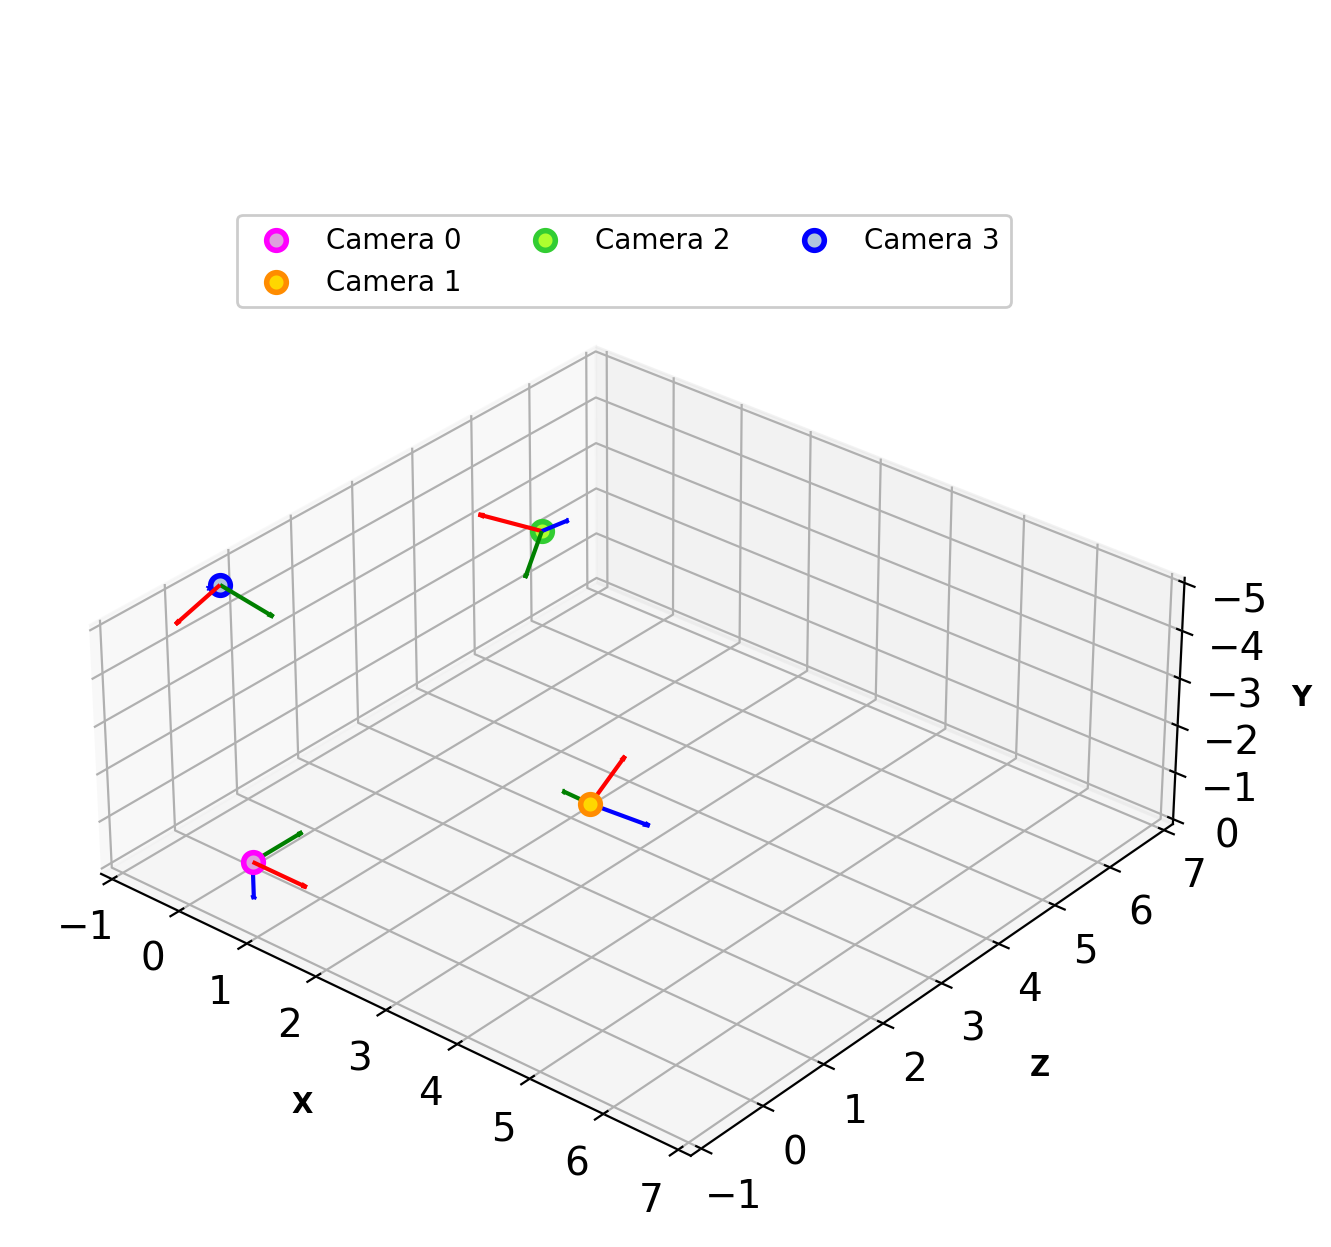

In [218]:
# plot 3d map
fig = plt.figure(figsize=(8, 8),dpi=200)
ax = plt.axes(projection='3d')
ax.set_xlim(-1, 7)
ax.set_zlim(-5, 0)
ax.set_ylim(-1, 7)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_xlabel('X', fontweight='bold',labelpad=15)
ax.set_ylabel('Z', fontweight='bold',labelpad=15)
ax.set_zlabel('Y', fontweight='bold',labelpad=5)
cmhot = plt.get_cmap("jet")
ax.view_init(elev=30, azim=-50) 
plt.gca().invert_zaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .5, 1.]))
colours = [['fuchsia','plum'],['darkorange','gold'],['limegreen','greenyellow'],['blue','lightsteelblue']]

for j in range(nCameras):
    # plot camera
    k = 0.8
    x,y,z= np.array([k, 0, 0, 0]), np.array([0, k, 0, 0]),np.array([0, 0, k, 0])
    t,R,lamb = np.array(translation[j][0]).reshape(-1,3),np.array(rotation[j]),scale[j]
    t_new = np.matmul(-t, R).reshape(-1,3)*lamb/100
    P_new = np.vstack((np.hstack((R.T,t_new.T)),np.hstack((np.zeros((3)),1))))
    x,y,z = np.matmul(P_new,x),np.matmul(P_new,y),np.matmul(P_new,z)
    o = np.matmul(P_new,[[0.],[0.],[0.],[1]]).ravel()
    ax.quiver(o[0], o[2], o[1], x[0], x[2], x[1], arrow_length_ratio=0.1, edgecolors="r")
    ax.quiver(o[0], o[2], o[1], y[0], y[2], y[1], arrow_length_ratio=0.1, edgecolors="b")
    ax.quiver(o[0], o[2], o[1], z[0], z[2], z[1], arrow_length_ratio=0.1, edgecolors="g")
    ax.scatter(o[0], o[2], o[1], s=50, edgecolor=colours[j][0], facecolor=colours[j][1], linewidth=2,  label = 'Camera '+str(j))

'''
# when using composition
for j in range(nCameras):
    # plot camera
    k = 0.8
    x,y,z= np.array([k, 0, 0, 0]), np.array([0, k, 0, 0]),np.array([0, 0, k, 0])
    P_new = np.vstack((np.hstack((np.identity(3),np.zeros((3,1)))),np.hstack((np.zeros((3)),1))))
    for i in np.flip(range(j+1)):
        t,R,lamb = np.array(translation[i][0]).reshape(-1,3),np.array(rotation[i]),scale[i]
        t_new = np.matmul(-t, R).reshape(-1,3)*lamb/100
        P = np.vstack((np.hstack((R.T,t_new.T)),np.hstack((np.zeros((3)),1))))
        P_new = np.matmul(P,P_new)
    x,y,z = np.matmul(P_new,x),np.matmul(P_new,y),np.matmul(P_new,z)
    o = np.matmul(P_new,[[0.],[0.],[0.],[1]]).ravel()
    ax.quiver(o[0], o[2], o[1], x[0], x[2], x[1], arrow_length_ratio=0.1, edgecolors="r")
    ax.quiver(o[0], o[2], o[1], y[0], y[2], y[1], arrow_length_ratio=0.1, edgecolors="b")
    ax.quiver(o[0], o[2], o[1], z[0], z[2], z[1], arrow_length_ratio=0.1, edgecolors="g")
    ax.scatter(o[0], o[2], o[1], s=50, edgecolor=colours[j][0], facecolor=colours[j][1], linewidth=2,  label = 'Camera '+str(j))'''

# plot commands
plt.legend(ncol=3,loc ='center',edgecolor='silver', bbox_to_anchor=(0.5, 0.8)) 
plt.draw()
plt.show()